---
title: "Transmission of High Effciency Dielectric Huygens Surface"
jupyter: python3
---

# 

Author: Alex Meng

Redo: 8/28/2025

Important Questions to answer:

:::{}
- Why do we need a normalizing run? (FDTD 101)
- Why is there a mismatch between `td.FreqRange.wvl0` and `td.C_0 / td.FreqRange.freq0` 
:::

[Huygens' Metasurface Paper Link](https://duke.box.com/s/03x3nr1clvwb9c99z7ii6kb7o8fq1uyv)

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Preconditions

In [66]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.1, wvl_max=1.6)
N = 301 # num_points

In [67]:
# 1 Computational domain size
h = 0.220  # Height of cylinder
spc = 2
Lz = spc + h + h + spc

Px = Py = P = 0.666 # periodicity
sim_size = [Px, Py, Lz]

In [68]:
# 2 Grid Specifications
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

In [69]:
# 3 Structures
r = 0.242  # radius of the cylinder
n_Si = 3.5
Si = td.Medium(permittivity=n_Si**2, name='Si')
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)

# Spin_on glass + substrate
n_glass = 1.4
n_SiO2 = 1.45
glass = td.Medium(permittivity=n_glass**2, name='glass')
SiO2 = td.Medium(permittivity=n_SiO2**2, name='oxide')

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=SiO2,
    name='substrate'
)

glass = td.Structure(
    geometry=td.Box(
        center=(0,0,Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=glass,
    name='superstrate'
)

# Polymer
n_polymer = 1.66
polymer = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(td.inf,td.inf,td.inf)
    ),
    medium=td.Medium(permittivity=n_polymer**2, name='polymer'),
    name='polymer'
)

In [70]:
# 4 Sources
source = td.PlaneWave(
    source_time=fr.to_gaussian_pulse(),
    size=(td.inf, td.inf, 0),
    center=(0, 0, Lz/2 - spc + 2 * dl),
    direction="-",
    pol_angle=0
)

In [71]:
# 5 Monitor
monitor = td.FluxMonitor(
    center=(0, 0, -Lz/2 + spc - 2*dl),
    size=(td.inf, td.inf, 0),
    freqs=fr.freqs(N),
    name="flux"
)

In [72]:
# 6 Run Time
bandwidth = fr.fmax - fr.fmin
run_time= 50 / bandwidth

In [73]:
# 7 Boundary Condition
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

## Simulation 

In [74]:
sim_empty=td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, glass],
    sources=[source],
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=bc
)

In [75]:
sim_actual = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, glass, cylinder],
    sources=[source],
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=bc
)

<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

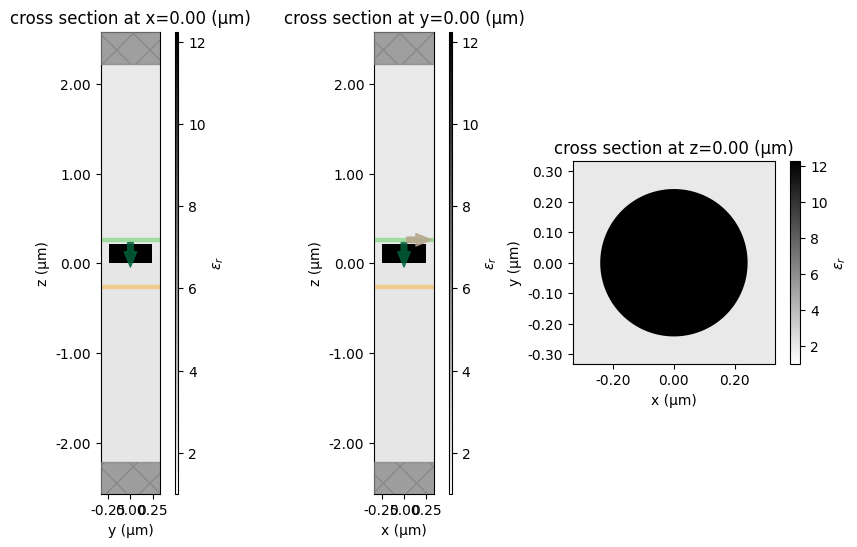

In [76]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 6))
sim_actual.plot_eps(x=0, ax=ax1)
sim_actual.plot_eps(y=0, ax=ax2)
sim_actual.plot_eps(z=0, ax=ax3)

In [77]:
sims = {
    "norm": sim_empty,
    "actual": sim_actual,
}

batch = web.Batch(simulations=sims, verbose=True)

In [78]:
batch_data = batch.run(path_dir="data")

Output()

00:11:07 UTC Started working on Batch containing 2 tasks.

             Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

00:11:08 UTC Batch complete.

Output()

## Postprocess

- 35 seconds to run both simulations
- results are stored inside `batch_data`

In [79]:
T = batch_data["actual"]["flux"].flux / batch_data["norm"]["flux"].flux

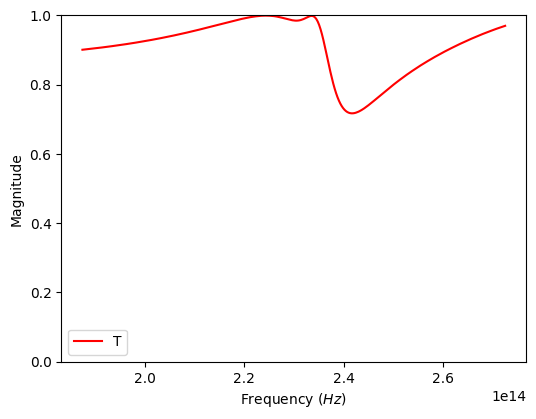

In [80]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(fr.freqs(N), T, "r", label="T")
plt.xlabel(r"Frequency ($Hz$)")
plt.ylabel("Magnitude")
plt.ylim(0, 1)
plt.legend()
plt.show()

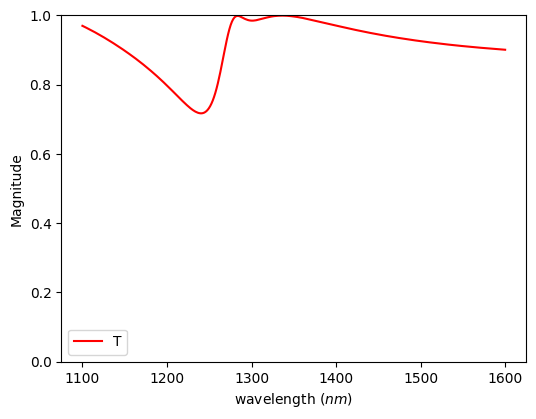

In [81]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T, "r", label="T")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Magnitude")
plt.ylim(0, 1)
plt.legend()
plt.show()